<a href="https://colab.research.google.com/github/ekalmes/Portfolio/blob/main/Predicting_NHL_Player_Salaries_Using_Various_Forms_of_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting NHL Player Salaries
In this notebook, I will be taking a look at different factors that play into an NHL player's salary using different forms of Linear Regression. 

Written by: Zeke Kalmes

##Introduction


### Background on Player Salaries
For those who may not be familiar with how the financial side of the NHL works, there is a set league-wide salary cap, similar to other sports leagues. For the 2017-2018 season, the salary cap was set at 75 million dollars, and each players salary takes a "hit" on that number. Where the NHL differs from other sports leagues is how they calculate this cap hit. 

Say we take a look at Patrick Kane of the Chicago Blackhawks. His salary for the 2017-18 season was 13.8 million dollars; however, his cap hit is only 10.5 million for that season. Instead of the cap hit being the full 13.8 million he was paid that season, it is the Average Annual Value (AAV) of his contact, which is found by diving his overall contact value, 84 million, by the number of years of the contract, 8. This allows teams to front-load contracts of players who are aging, as well as allowing the teams to have a better projection of the remaining cap space for future seasons. 


### Credit for the Data Source 
This incredibly expansive dataset was built by Robert Vollman and can be found at http://www.hockeyabstract.com/testimonials/nhl2017-18. Vollman has put together statistical datasets for the NHL since the 2014-15 season. I have chosen to use just the 2017-18 year data, as it is the most current avaiable. 

### Process
For this analysis, I will be using the AAV of player contracts, rather than the actual salary amount for that season. AAV is a better indicator of a player's value, as it is more directly related to the salary cap for the team, and what other contracts they would be allowed to pick up. It evens the playing field, as some players may be making more or less for that season than their actual cap hit. 

In order to build my model, I will first need to do some data manipulation/cleaning, such as removing all categorical variables that cannot be factored into linear regression. Once this is done, I will be able to build some different models and visualizations to explore the question of what factors most influence salary. 

## Imports
Here I will be importing all the necessary python libraries, as well as the dataset, for this analysis. 

In [ ]:
#Python Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#imports and functions for authenticating google account
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1B3ko_zWhuQuoam4CpNXCs69FZmdgXmWi'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
# user must download file
downloaded.GetContentFile('nhlsalarydata.xlsx')

In [ ]:
!ls -lha nhlsalarydata.xlsx

-rw-r--r-- 1 root root 3.2M Oct  2 15:20 nhlsalarydata.xlsx


In [ ]:
#Now to import to pandas df
!pip install -q xlrd

import pandas as pd
df = pd.read_excel('nhlsalarydata.xlsx')
df.head()

,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Debut,Age,Seasons,NHLid,CorsicaID,H-Ref Name,Last Name,First Name,Position,Team,GP,G,A,A1,PTS,Rnk,Gap,PTS/GP,PAX,GC,+/-,E+/-,PIM,Shifts,TOI,TOI.1,TOI.2,TOI.3,TOI/GP,...,PENT,PEND,OPS,DPS,PS,GS,GS/G,Star,OWAR,DWAR,WAR,SOS,SOG,SOGDG,Grit,DAP,Pres,IceF,IceA,CPP,CPP.1,Pace,CruG,CruA1,CruA2,CriG,CriA1,CriA2,MGL,Injuries,CHIP,NMC,Status,Salary,Cap Hit,Stick,Glove,Pants,Helmet,Skates
0,1989-11-21,Dorchester,MA,USA,USA,77,215,2008.0,2.0,60.0,R,2011,28,7,8474625,JIMMY.HAYES,Jimmy Hayes,Hayes,Jimmy,RW,NJD,33,3,6,3,9,22,84,0.272727,0,3.394,-2,-1.5,6,491,23617,393.616667,393.33,394,11.927778,...,23,21,0.2,0.4,0.6,4.95,0.150000,1.2880,-0.06,-0.16,-0.22,NaN,NaN,NaN,62,21.666667,0.031061,32,40,8.4,8.5660,107.390741,1,2,2,0,0,0,NaN,NaN,NaN,NaN,UFA,700000.0,700000.0,Warrior - Covert QRL,Bauer - Vapor 1X,Bauer,Bauer - 4500,TRUE - Pro Custom
1,1987-12-23,Helsinki,NaN,FIN,FIN,74,212,2008.0,3.0,65.0,L,2014,30,4,8474627,JORI.LEHTERA,Jori Lehtera,Lehtera,Jori,C,PHI,62,3,5,1,8,19,94,0.129032,0,2.908,-8,-3.2,14,952,39114,651.900000,651.90,652,10.514516,...,30,40,-0.7,0.4,-0.4,7.79,0.125645,0.0988,-0.41,-0.05,-0.46,NaN,NaN,NaN,90,9.857143,0.016129,49,68,6.6,7.8576,104.279798,2,0,3,0,0,1,1.0,Illness,57.0,NaN,UFA,4700000.0,4700000.0,Warrior - Alpha QX,Warrior - Dynasty AX1,Warrior,CCM - Vector V08,Bauer - Vapor 1X
2,1990-06-07,Winnipeg,MB,CAN,CAN,75,210,2008.0,3.0,69.0,R,2011,27,7,8474628,MICHAEL.STONE,Michael Stone,Stone,Michael,D,CGY,82,3,7,5,10,17,74,0.121951,0,3.527,-11,0.4,28,1759,82396,1373.266667,1373.23,1373,16.747154,...,102,118,-0.4,2.5,2.2,18.68,0.227805,0.7003,0.17,-0.02,0.15,NaN,NaN,NaN,292,8.642857,0.014085,102,109,7.2,9.8486,117.533115,2,0,1,1,0,0,NaN,NaN,NaN,NTC,UFA,3500000.0,3500000.0,Warrior - Alpha QX,Bauer - Supreme 1S,Warrior,Bauer - 5100,Bauer - Supreme 1S
3,1982-04-18,Regina,SK,CAN,CAN,74,215,2000.0,1.0,6.0,L,2000,35,17,8468486,SCOTT.HARTNELL,Scott Hartnell,Hartnell,Scott,LW,NSH,62,13,11,8,24,14,40,0.387097,0,9.870,-3,-3.7,82,1099,44707,745.116667,745.13,745,12.018011,...,72,62,1.8,0.6,2.4,23.66,0.381613,1.2581,0.84,-0.15,0.68,NaN,NaN,NaN,193,8.727273,0.069329,54,50,15.8,21.7136,112.651484,7,5,2,2,1,0,13.0,Lower body,159.0,NaN,UFA,1000000.0,1000000.0,Bauer - Vapor 1X Lite,Warrior - Dynasty AX1,Bauer,Bauer - 9900,TRUE - Pro Custom
4,1981-03-24,Bolton,CT,USA,USA,75,205,2000.0,1.0,13.0,L,2002,36,15,8468493,RON.HAINSEY,Ron Hainsey,Hainsey,Ron,D,TOR,80,4,19,8,23,12,46,0.287500,0,7.790,12,-5.1,20,2215,104951,1749.183333,1749.18,1749,21.864792,...,75,80,0.6,4.2,4.8,20.57,0.257125,1.2255,0.54,-0.18,0.36,NaN,NaN,NaN,280,10.900000,0.015414,138,152,21.0,23.2368,119.370219,2,5,6,1,2,1,4.0,Illness,195.0,M-NTC,UFA,3600000.0,3000000.0,Warrior - Alpha QX,Warrior - Dynasty AX1,Warrior,Warrior - Covert PX2,Bauer - Nexus 1N


## Examining Correlations
In this step, I will be producing a correlation table and then sorting it by Cap Hit to get an idea of which features will be the best predictors for Salary cap. 

In [ ]:
df.corr()['Cap Hit'].abs().sort_values(ascending = False)

Cap Hit    1.000000
Salary     0.983642
OZS        0.671667
xGF        0.667911
GF         0.659515
             ...   
NPD        0.013936
MGL        0.002081
DAP        0.001447
Maj        0.001152
PAX             NaN
Name: Cap Hit, Length: 173, dtype: float64

With many of the features having correlations above 0.60, there is a good selection of features that could be good predictors for Cap Hit. 

## Initial Visualizations
In this step, I will produce some visualizations to compare the two features of choice to the outcome. I chose to use xGF (The team's expected goals (weighted shots) while this player was on the ice, which is shot attempts weighted by location), which had a correlation of ~0.67, and average time on ice per game (TOI, same as playing time in other sports), which had a correlation of ~0.61. I chose these because they are two relatively easy-to-understand metrics, and both are good guages of how valuable a player is to their team. 

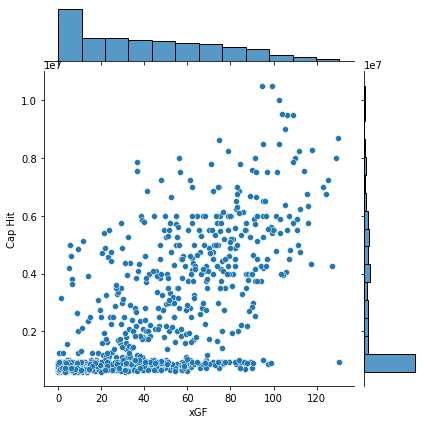

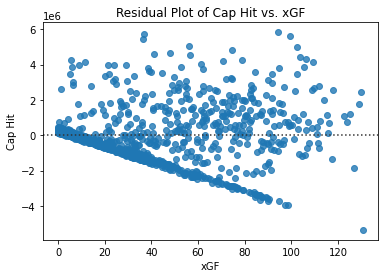

In [ ]:
#create plots
sns.jointplot(x=df['xGF'], y=df['Cap Hit'], data=df)
plt.show()
sns.residplot(x=df['xGF'], y=df['Cap Hit'], data=df)
plt.title('Residual Plot of Cap Hit vs. xGF')
plt.show()

These plots, especially the residuals plot, give a insights into the data. For one, the data in both series are not very normally distributed. For two, there are multiple players who are due for a raise, as they are reaching high have a high xGF with a low salary. This might lead to some higher errors come time for the linear regression. 

Next up is Cap Hit vs TOI.

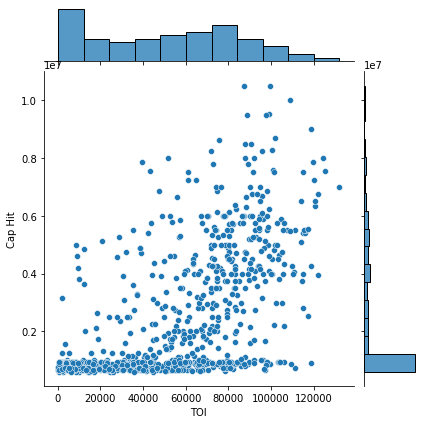

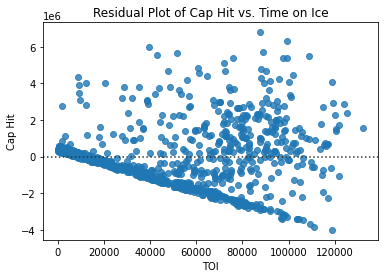

In [ ]:
#create plots
sns.jointplot(x=df['TOI'], y=df['Cap Hit'], data=df)
plt.show()
sns.residplot(x=df['TOI'], y=df['Cap Hit'], data=df)
plt.title('Residual Plot of Cap Hit vs. Time on Ice')
plt.show()

Again, we see a simlar trend as with xGF, but there is a bit more normal of a distribution within TOI.

## Simple Linear Regression

Here I will begin the linear regression step. I first need to do some cleaning of the data, and then I can get started. 

In [ ]:
#create dataframe with only desired features
#starting with xGF
df_xgf = df[['Cap Hit', 'xGF']]

#drop any rows with na values
df_xgf_droppedna = df_xgf.dropna()

### Points

In [ ]:
#Initializing the linear regression object
NHLxgf_regression = LinearRegression(normalize=True)

In [ ]:
# setting outcome variable, y_xgf, equal to an array of the Cap Hit series
y_xgf = df_xgf_droppedna['Cap Hit'].values.reshape(len(df_xgf_droppedna['Cap Hit']), 1)

# setting feature variable, X_xgf, equal to an array of the xGF series
X_xgf = df_xgf_droppedna['xGF'].values.reshape(len(df_xgf_droppedna['xGF']), 1)

In [ ]:
# fitting regression object to the xgf and cap hit data
NHLxgf_regression.fit(X_xgf, y_xgf)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
# printing out regression metrics 
print('Intercept = ', round(NHLxgf_regression.coef_.item(), 2))
print('Coefficient = ', round(NHLxgf_regression.intercept_.item(), 2))
print('R squared = ', round(NHLxgf_regression.score(X_xgf, y_xgf), 2))

Intercept =  44492.4
Coefficient =  472753.13
R squared =  0.45


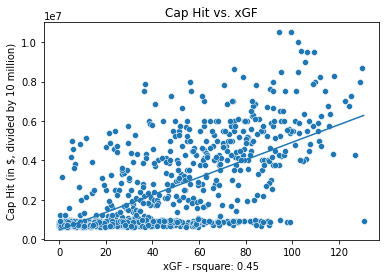

In [ ]:
# plotting the regression
predicted_y = NHLxgf_regression.predict(X_xgf)

#flattening arrays using .flatten() in order to plot them
X_flat = X_xgf.flatten()
y_flat = predicted_y.flatten()

# get min and max of X
X_min = X_xgf.min()
X_max = X_xgf.max()

# use the min and max to get the predictions
predicted_y_min = NHLxgf_regression.predict([[X_min]]).item()
predicted_y_max = NHLxgf_regression.predict([[X_max]]).item()

# plot the line and the scatter
sns.lineplot(x = [X_min, X_max], y = [predicted_y_min, predicted_y_max])
sns.scatterplot(x = 'xGF', y = 'Cap Hit', data = df_xgf_droppedna)
plt.xlabel('xGF - rsquare: ' + str(round(NHLxgf_regression.score(X_xgf, y_xgf), 2)))
plt.ylabel('Cap Hit (in $, divided by 10 million)')
plt.title('Cap Hit vs. xGF')
plt.show()

### Time on Ice

This step will looking very similar to the last one, just with TOI instead of xGF.

In [ ]:
#create dataframe with only desired features
df_toi = df[['Cap Hit', 'TOI']]

#drop any rows with na values
df_toi_droppedna = df_toi.dropna()

In [ ]:
#Initializing the linear regression object
NHLtoi_regression = LinearRegression(normalize=True)

In [ ]:
# setting outcome variable, y_toi, equal to an array of the Cap Hit series
y_toi = df_toi_droppedna['Cap Hit'].values.reshape(len(df_toi_droppedna['Cap Hit']), 1)

# setting feature variable, X_toi, equal to an array of the TOI series
X_toi = df_toi_droppedna['TOI'].values.reshape(len(df_toi_droppedna['TOI']), 1)

In [ ]:
# fitting regression object to the toi and cap hit data
NHLtoi_regression.fit(X_toi, y_toi)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
# printing out regression metrics 
print('Intercept = ', round(NHLtoi_regression.coef_.item(), 2))
print('Coefficient = ', round(NHLtoi_regression.intercept_.item(), 2))
print('R squared = ', round(NHLtoi_regression.score(X_toi, y_toi), 2))

Intercept =  38.48
Coefficient =  334783.23
R squared =  0.37


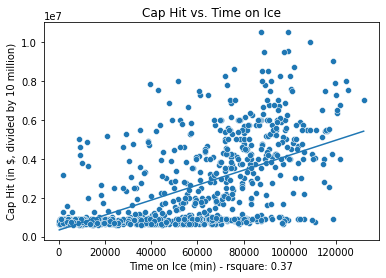

In [ ]:
# plotting the regression
predicted_y = NHLtoi_regression.predict(X_toi)

#flattening arrays using .flatten() in order to plot them
X_flat = X_toi.flatten()
y_flat = predicted_y.flatten()

# get min and max of X
X_min = X_toi.min()
X_max = X_toi.max()

# use the min and max to get the predictions
predicted_y_min = NHLtoi_regression.predict([[X_min]]).item()
predicted_y_max = NHLtoi_regression.predict([[X_max]]).item()

# plot the line and the scatter
sns.lineplot(x = [X_min, X_max], y = [predicted_y_min, predicted_y_max])
sns.scatterplot(x = 'TOI', y = 'Cap Hit', data = df_toi_droppedna)
plt.xlabel('Time on Ice (min) - rsquare: ' + str(round(NHLtoi_regression.score(X_toi, y_toi), 2)))
plt.ylabel('Cap Hit (in $, divided by 10 million)')
plt.title('Cap Hit vs. Time on Ice')
plt.show()

### SLR Conclusion
Conclusion
In conclusion, I have found that xGF is a better predictor than TOI, but with some caveats. Both features had a relatively high correlation with cap hit, but there were issues within the regression itself. The salary cap median is $925,000, which explains why the bottom of each graph is tightly packed, and the upper portions are more spread out. This non-normal distribution causes the r-squared scores to drop.

## Moving Forward
From the last step, I can see that I need to split the cap hit into two groups based on the median in order to get a more normal distribution

In [ ]:
print(df['Cap Hit'].median())
df_cap_upper = df[df['Cap Hit'] > 925000]
df_cap_lower = df[df['Cap Hit'] <= 925000]

925000.0


In [ ]:
df_cap_upper.corr()['Cap Hit'].abs().sort_values(ascending = False)

Cap Hit    1.000000
Salary     0.967954
OZS        0.625239
xGF        0.602296
A          0.592416
             ...   
G.Wrap     0.014931
Match      0.014099
sDist      0.010245
Game       0.005686
PAX             NaN
Name: Cap Hit, Length: 173, dtype: float64

In [ ]:
df_cap_lower.corr()['Cap Hit'].abs().sort_values(ascending = False)

Cap Hit    1.000000
Salary     0.964261
DftYr      0.462875
Age        0.459026
DftRd      0.435926
             ...   
Wt         0.016040
iPENT5     0.003780
Maj        0.003564
iPEND5     0.000357
PAX             NaN
Name: Cap Hit, Length: 173, dtype: float64

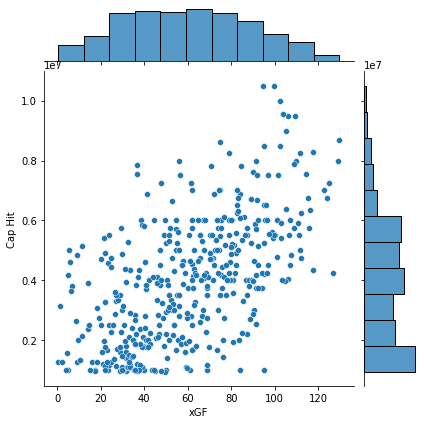

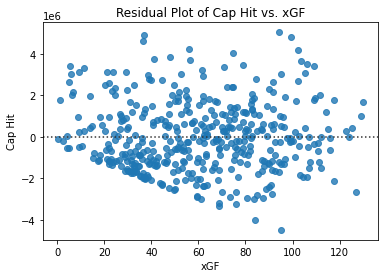

In [ ]:
sns.jointplot(x=df_cap_upper['xGF'], y=df_cap_upper['Cap Hit'], data=df_cap_upper)
plt.show()
sns.residplot(x=df_cap_upper['xGF'], y=df_cap_upper['Cap Hit'], data=df_cap_upper)
plt.title('Residual Plot of Cap Hit vs. xGF')
plt.show()

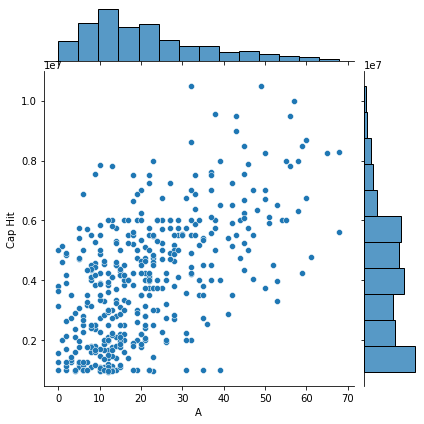

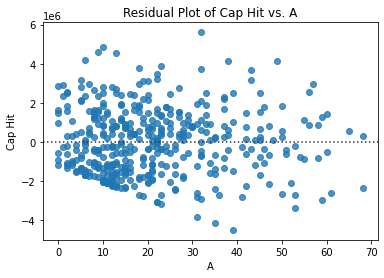

In [ ]:
sns.jointplot(x=df_cap_upper['A'], y=df_cap_upper['Cap Hit'], data=df_cap_upper)
plt.show()
sns.residplot(x=df_cap_upper['A'], y=df_cap_upper['Cap Hit'], data=df_cap_upper)
plt.title('Residual Plot of Cap Hit vs. A')
plt.show()

In [ ]:
X = df_cap_upper[['xGF', 'A']]
y = df_cap_upper['Cap Hit']

# create a linear regression class instance
my_regression = LinearRegression(normalize=False)

# fit the model
my_regression.fit(X,y)

print('intercept = ', my_regression.intercept_)
print('xGf coefficient = ', my_regression.coef_[0])
print('A coefficient = ', my_regression.coef_[1])
print('R squared = ', round(my_regression.score(X, y), 2))

intercept =  1523820.5465672296
xGf coefficient =  25821.623577667386
A coefficient =  42111.12321897929
R squared =  0.39
